In [ ]:
# 이 코드 예시는 기존 파이프라인 구조를 확장하여 다양한 Shape(원, 사다리꼴, 스파이크, 기둥, 직사각형, 타원, 언덕, 안개, 다각형, 파형, 실제 음원)과
# Pattern(선형, 랜덤, n번 반복 후 t초 정지, 볼록, 임의 함수 기반)을 추가하는 방법의 개략적 구조를 제안한다.
# 각 Shape와 Pattern은 DB 기반 스펙트로그램에 노이즈 패턴을 추가할 수 있도록 구성.
# 실제 구현에서는 각 Shape/Pattern의 마스킹 로직, 수학적 변환, 오디오 합성 등이 필요하다.
#
# PEP8 스타일 준수 및 한글 주석
# 주어진 Shape와 Pattern들을 유연하게 팩토리 및 파이프라인에 통합한 예시 코드.

import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from abc import ABC, abstractmethod


class SpectrogramModifier:
    def __init__(self, sample_rate=16000, n_fft=1024, hop_length=512,
                 noise_strength=0.1, noise_type='normal', noise_params=None):
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.noise_strength = noise_strength
        self.noise_type = noise_type
        self.noise_params = noise_params if noise_params else {}
        self.signal = None
        self.signal_with_noise = None
        self.S_db = None

    def _generate_normal_noise(self, length, params):
        mean = params.get('mean', 0.0)
        std = params.get('std', 1.0)
        return np.random.normal(mean, std, length)

    def _generate_uniform_noise(self, length, params):
        low = params.get('low', -1.0)
        high = params.get('high', 1.0)
        return np.random.uniform(low, high, length)

    def _generate_perlin_noise(self, length, params):
        def fade(t):
            return 6*t**5 - 15*t**4 + 10*t**3

        seed = params.get('seed', 42)
        np.random.seed(seed)
        perm = np.arange(256)
        np.random.shuffle(perm)
        perm = np.stack([perm, perm]).flatten()
        scale = params.get('scale', 50.0)
        xs = np.linspace(0, length/scale, length)
        xi = np.floor(xs).astype(int)
        xf = xs - xi
        xi = xi % 256
        left_hash = perm[xi]
        right_hash = perm[xi+1]
        u = fade(xf)
        left_grad = ((left_hash & 1)*2-1)*xf
        right_grad = ((right_hash & 1)*2-1)*(xf-1)
        noise = (1-u)*left_grad + u*right_grad
        noise = noise / np.max(np.abs(noise))
        return noise

    def generate_noise(self, signal):
        length = len(signal)
        nt = self.noise_type
        p = self.noise_params
        if nt == 'normal':
            noise = self._generate_normal_noise(length, p)
        elif nt == 'uniform':
            noise = self._generate_uniform_noise(length, p)
        elif nt == 'perlin':
            noise = self._generate_perlin_noise(length, p)
        else:
            noise = np.zeros_like(signal)
        return signal + noise * self.noise_strength

    def compute_spectrogram(self, signal):
        self.signal = signal
        self.signal_with_noise = self.generate_noise(signal)
        S = np.abs(librosa.stft(
            self.signal_with_noise, n_fft=self.n_fft, hop_length=self.hop_length, window='hann'))
        self.S_db = librosa.amplitude_to_db(S, ref=np.max)
        return self.S_db

    def _get_freqs(self):
        return np.linspace(0, self.sample_rate / 2, self.S_db.shape[0])

    def _get_times(self):
        return librosa.frames_to_time(np.arange(self.S_db.shape[1]),
                                      sr=self.sample_rate,
                                      hop_length=self.hop_length)

    def apply_dB_mask(self, dB_mask):
        self.S_db += dB_mask

    def plot_spectrogram(self, show_labels=True, colormap='magma', title='Spectrogram'):
        if self.S_db is None:
            raise ValueError("compute_spectrogram() 먼저 호출")
        fig, ax = plt.subplots(figsize=(12, 6))
        img = librosa.display.specshow(
            self.S_db,
            sr=self.sample_rate,
            hop_length=self.hop_length,
            x_axis='time',
            y_axis='linear',
            ax=ax,
            cmap=colormap
        )
        if show_labels:
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('Frequency (Hz)')
            ax.set_title(title)
            fig.colorbar(img, ax=ax, format="%+2.0f dB")
        else:
            ax.axis('off')
            plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        plt.tight_layout(pad=0.5)
        return fig, ax


import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from abc import ABC, abstractmethod

class Distribution(ABC):
    @abstractmethod
    def sample(self, shape):
        pass

class NormalDistribution(Distribution):
    def __init__(self, mean, stddev):
        self.mean = mean
        self.stddev = stddev
    def sample(self, shape):
        return np.random.normal(self.mean, self.stddev, shape)

class UniformDistribution(Distribution):
    def __init__(self, min_val, max_val):
        self.min_val = min_val
        self.max_val = max_val
    def sample(self, shape):
        return np.random.uniform(self.min_val, self.max_val, shape)

class NoneDistribution(Distribution):
    def sample(self, shape):
        return np.zeros(shape)

class PoissonDistribution(Distribution):
    def __init__(self, lam=5):
        self.lam = lam
    def sample(self, shape):
        # Poisson은 양의 정수형이라 평균을 lam으로 정규화
        # dB 값으로 사용하려면 변환 필요할 수 있으나 여기서는 그대로 사용
        return np.random.poisson(self.lam, shape).astype(float)

class ExponentialDistribution(Distribution):
    def __init__(self, scale=1.0):
        self.scale = scale
    def sample(self, shape):
        # 지수분포는 양수에 치우쳐 있으므로 평균 0 만들기 위해 shift
        noise = np.random.exponential(self.scale, shape)
        noise -= np.mean(noise)
        return noise

class CauchyDistribution(Distribution):
    def sample(self, shape):
        noise = np.random.standard_cauchy(shape)
        # 극단값 제거
        noise = np.clip(noise, -10, 10)
        noise = noise / np.max(np.abs(noise))
        return noise

class LaplaceDistribution(Distribution):
    def __init__(self, loc=0.0, scale=1.0):
        self.loc = loc
        self.scale = scale
    def sample(self, shape):
        return np.random.laplace(self.loc, self.scale, shape)

class BetaDistribution(Distribution):
    def __init__(self, a=2.0, b=2.0):
        self.a = a
        self.b = b
    def sample(self, shape):
        noise = np.random.beta(self.a, self.b, shape)
        # [0,1] -> [-1,1]
        noise = (noise - 0.5)*2
        return noise

class GammaDistribution(Distribution):
    def __init__(self, shape_param=2.0, scale=1.0):
        self.shape_param = shape_param
        self.scale = scale
    def sample(self, shape):
        noise = np.random.gamma(self.shape_param, self.scale, shape)
        # Gamma는 양수만 존재, 평균0 만들고 정규화
        noise -= np.mean(noise)
        noise = noise / (np.std(noise) + 1e-9)
        return noise

class ChiSquareDistribution(Distribution):
    def __init__(self, df=2):
        self.df = df
    def sample(self, shape):
        noise = np.random.chisquare(self.df, shape)
        noise -= np.mean(noise)
        noise = noise / (np.std(noise) + 1e-9)
        return noise

class DistributionEngine:
    def create(self, dist_type, **params):
        dist_type = dist_type.lower()
        if dist_type == "normal":
            return NormalDistribution(params.get('mean', 0), params.get('stddev', 1))
        elif dist_type == "uniform":
            return UniformDistribution(params.get('min', -1), params.get('max', 1))
        elif dist_type == "poisson":
            return PoissonDistribution(params.get('lam', 5))
        elif dist_type == "exponential":
            return ExponentialDistribution(params.get('scale', 1.0))
        elif dist_type == "cauchy":
            return CauchyDistribution()
        elif dist_type == "laplace":
            return LaplaceDistribution(params.get('loc', 0.0), params.get('scale', 1.0))
        elif dist_type == "beta":
            return BetaDistribution(params.get('a', 2.0), params.get('b', 2.0))
        elif dist_type == "gamma":
            return GammaDistribution(params.get('shape_param', 2.0), params.get('scale', 1.0))
        elif dist_type == "chisquare":
            return ChiSquareDistribution(params.get('df', 2))
        else:
            return NoneDistribution()


##################################
# 다양한 Shape 클래스 구현 (DBShape)
# 여기서는 마스킹 로직을 간략히 표기
##################################

class DBShape(ABC):
    @abstractmethod
    def create_mask(self, spectro_shape, spectro_mod):
        pass

class BaseShape(DBShape):
    def __init__(self, distribution_engine, distribution_type='none', distribution_params=None):
        self.distribution_engine = distribution_engine
        self.distribution_type = distribution_type
        self.distribution_params = distribution_params if distribution_params else {}

    def _sample_distribution(self, shape):
        dist_obj = self.distribution_engine.create(self.distribution_type, **self.distribution_params)
        return dist_obj.sample(shape)

    @abstractmethod
    def generate_shape_mask(self, spectro_shape, spectro_mod):
        pass

    def create_mask(self, spectro_shape, spectro_mod):
        shape_mask = self.generate_shape_mask(spectro_shape, spectro_mod)
        # shape_mask는 도형 내부 1, 외부 0
        # distribution_type이 'none'이 아니라면 distribution 샘플링
        if self.distribution_type != 'none':
            dist_values = self._sample_distribution(spectro_shape)
            return shape_mask * dist_values
        else:
            # distribution을 사용하지 않는 경우, shape_mask 자체에 일정한 dB값을 더하도록
            # 이 경우 shape_mask 자체가 dB값을 담고 있을 수도 있음.
            return shape_mask    

# 원 형태 노이즈
class CircleDBShape(BaseShape):
    def __init__(self, center_freq, center_time, radius_freq, radius_time, strength_dB,
                 distribution_engine, distribution_type='none', distribution_params=None):
        super().__init__(distribution_engine, distribution_type, distribution_params)
        self.center_freq = center_freq
        self.center_time = center_time
        self.radius_freq = radius_freq
        self.radius_time = radius_time
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')
        dist = ((ff - self.center_freq)**2 / (self.radius_freq**2) +
                (tt - self.center_time)**2 / (self.radius_time**2))
        circle = (dist <= 1).astype(float)
        # distribution_type='none'일 때 사용될 기본 dB 값
        return circle * self.strength_dB
    
# 사다리꼴 형태 노이즈
class TrapezoidDBShape(BaseShape):
    def __init__(self, freq_min, freq_max, time_min, time_max, slope_freq, slope_time, strength_dB,
                 distribution_engine, distribution_type='none', distribution_params=None):
        super().__init__(distribution_engine, distribution_type, distribution_params)
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.time_min = time_min
        self.time_max = time_max
        self.slope_freq = slope_freq
        self.slope_time = slope_time
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        freq_mask = (freqs >= self.freq_min) & (freqs <= self.freq_max)
        time_mask = (times >= self.time_min) & (times <= self.time_max)
        f_inds = np.where(freq_mask)[0]
        t_inds = np.where(time_mask)[0]
        if len(f_inds) == 0 or len(t_inds) == 0:
            return mask
        f_dist = (freqs[f_inds] - self.freq_min) / (self.freq_max - self.freq_min)
        t_dist = (times[t_inds] - self.time_min) / (self.time_max - self.time_min)
        for i, fi in enumerate(f_inds):
            for j, ti in enumerate(t_inds):
                val = self.strength_dB * (1 - abs(f_dist[i]-0.5)*2*self.slope_freq) * (1 - abs(t_dist[j]-0.5)*2*self.slope_time)
                mask[fi, ti] += val
        return mask

# 스파이크 형태 (주파수나 시간 특정 지점에 뾰족한 형태)
class SpikeDBShape(BaseShape):
    def __init__(self, distribution_engine, center_freq, center_time, radius_freq, radius_time, strength_dB,
                 rotate=(0, 0), distribution_type='none', distribution_params=None):
        super().__init__(distribution_engine, distribution_type, distribution_params)
        self.center_freq = center_freq
        self.center_time = center_time
        self.radius_freq = radius_freq
        self.radius_time = radius_time
        self.strength_dB = strength_dB
        self.rotate_deg = rotate[0]

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')

        f_shift = ff - self.center_freq
        t_shift = tt - self.center_time

        angle_rad = np.deg2rad(self.rotate_deg)
        cos_a = np.cos(angle_rad)
        sin_a = np.sin(angle_rad)

        f_rot = f_shift * cos_a - t_shift * sin_a
        t_rot = f_shift * sin_a + t_shift * cos_a

        dist = np.sqrt((f_rot**2) / (self.radius_freq**2) + (t_rot**2) / (self.radius_time**2))
        spike = np.exp(-dist*5) * self.strength_dB
        return spike

# 기둥 형태
class PillarDBShape(BaseShape):
    def __init__(self, freq_min, freq_max, strength_dB, distribution_engine, distribution_type='none', distribution_params=None):
        super().__init__(distribution_engine, distribution_type, distribution_params)
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        freqs = spectro_mod._get_freqs()
        freq_indices = np.where((freqs >= self.freq_min) & (freqs <= self.freq_max))[0]
        if len(freq_indices) == 0:
            return mask
        mask[freq_indices, :] += self.strength_dB
        return mask

# 직사각형 형태
class RectangleDBShape(BaseShape):
    def __init__(self, freq_min, freq_max, time_min, time_max, strength_dB,
                 distribution_engine, distribution_type='none', distribution_params=None):
        super().__init__(distribution_engine, distribution_type, distribution_params)
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.time_min = time_min
        self.time_max = time_max
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        freq_indices = np.where((freqs >= self.freq_min) & (freqs <= self.freq_max))[0]
        time_indices = np.where((times >= self.time_min) & (times <= self.time_max))[0]
        if len(freq_indices) == 0 or len(time_indices) == 0:
            return mask
        mask[np.ix_(freq_indices, time_indices)] += self.strength_dB
        return mask

# 타원 형태
class EllipseDBShape(BaseShape):
    def __init__(self, center_freq, center_time, radius_freq, radius_time, strength_dB,
                 distribution_engine, distribution_type='none', distribution_params=None):
        super().__init__(distribution_engine, distribution_type, distribution_params)
        self.center_freq = center_freq
        self.center_time = center_time
        self.radius_freq = radius_freq
        self.radius_time = radius_time
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')
        dist = ((ff - self.center_freq)**2 / (self.radius_freq**2) +
                (tt - self.center_time)**2 / (self.radius_time**2))
        ellipse = (dist <= 1).astype(float)
        return ellipse * self.strength_dB

# 언덕 형태
class HillDBShape(BaseShape):
    def __init__(self, freq_center, time_center, freq_width, time_width, strength_dB,
                 distribution_engine, distribution_type='none', distribution_params=None):
        super().__init__(distribution_engine, distribution_type, distribution_params)
        self.freq_center = freq_center
        self.time_center = time_center
        self.freq_width = freq_width
        self.time_width = time_width
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')
        dist = np.sqrt(((ff - self.freq_center)**2) / (self.freq_width**2) +
                       ((tt - self.time_center)**2) / (self.time_width**2))
        hill = (1 - dist)
        hill[hill < 0] = 0
        return hill * self.strength_dB
    
# 안개(fog): 전체 구간에 랜덤 저강도 노이즈
class FogDBShape(BaseShape):
    def __init__(self, strength_dB, coverage=1.0, distribution_engine=None, distribution_type='none', distribution_params=None):
        super().__init__(distribution_engine, distribution_type, distribution_params)
        self.strength_dB = strength_dB
        self.coverage = coverage

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        random_map = np.random.uniform(0, 1, spectro_shape)
        fog = (random_map < self.coverage).astype(float) * self.strength_dB * (np.random.randn(*spectro_shape) * 0.1)
        return fog

# 다각형(polygon): 주파수-시간 좌표계 상에 다각형을 정의하고 내부를 채움
class PolygonDBShape(BaseShape):
    def __init__(self, vertices, strength_dB, distribution_engine=None, distribution_type='none', distribution_params=None):
        super().__init__(distribution_engine, distribution_type, distribution_params)
        self.vertices = vertices
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        from matplotlib.path import Path
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')

        poly_points = [(v[0], v[1]) for v in self.vertices]
        path = Path(poly_points)
        points = np.vstack((ff.ravel(), tt.ravel())).T
        inside = path.contains_points(points).reshape(ff.shape)
        mask = np.zeros(spectro_shape)
        mask[inside] = self.strength_dB
        return mask

# 파형(wave pattern): sin, cos 형태로 dB 변조
class WavePatternDBShape(BaseShape):
    def __init__(self, axis='time', frequency=1.0, strength_dB=5.0, distribution_engine=None, distribution_type='none', distribution_params=None):
        super().__init__(distribution_engine, distribution_type, distribution_params)
        self.axis = axis
        self.frequency = frequency
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        mask = np.zeros(spectro_shape)
        if self.axis == 'time':
            wave = np.sin(2 * np.pi * self.frequency * times)
            mask += wave[np.newaxis, :] * self.strength_dB
        else:
            wave = np.sin(2 * np.pi * self.frequency * freqs)
            mask += wave[:, np.newaxis] * self.strength_dB
        return mask

# 실제 음원 삽입: 외부 wav/mp3 파일의 스펙트럼을 특정 구간에 합성
class RealWorldNoiseDBShape(BaseShape):
    def __init__(self, audio_path, freq_min, freq_max, time_min, time_max, strength_dB=0,
                 distribution_engine=None, distribution_type='none', distribution_params=None):
        super().__init__(distribution_engine, distribution_type, distribution_params)
        self.audio_path = audio_path
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.time_min = time_min
        self.time_max = time_max
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        # 음원 로드 후 스펙트럼 처리
        y, sr = librosa.load(self.audio_path, sr=spectro_mod.sample_rate)
        S = np.abs(librosa.stft(y, n_fft=spectro_mod.n_fft, hop_length=spectro_mod.hop_length))
        S_db = librosa.amplitude_to_db(S, ref=np.max)

        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        freq_indices = np.where((freqs >= self.freq_min) & (freqs <= self.freq_max))[0]
        time_indices = np.where((times >= self.time_min) & (times <= self.time_max))[0]

        if len(freq_indices) == 0 or len(time_indices) == 0:
            return np.zeros(spectro_shape)

        f_cut = min(len(freq_indices), S_db.shape[0])
        t_cut = min(len(time_indices), S_db.shape[1])

        mask = np.zeros(spectro_shape)
        mask[freq_indices[:f_cut], time_indices[:t_cut]] += S_db[:f_cut, :t_cut] + self.strength_dB
        return mask


##################################
# 패턴 클래스 구현 (시간/주파수 축으로 linear, random, n-time-linear-t-sleep, convex, function)
##################################

class Pattern(ABC):
    @abstractmethod
    def create_mask(self, spectro_shape, spectro_mod, shape_factory, distribution_engine):
        pass

# 선형 패턴: 주어진 shape를 time 또는 freq 방향으로 일정 간격 반복
class LinearPattern(Pattern):
    def __init__(self, shape_name, shape_params, direction='time', repeat=5, spacing=1.0):
        self.shape_name = shape_name
        self.shape_params = shape_params
        self.direction = direction
        self.repeat = repeat
        self.spacing = spacing

    def create_mask(self, spectro_shape, spectro_mod, shape_factory, distribution_engine):
        mask = np.zeros(spectro_shape)
        # direction에 따라 shape를 일정 간격으로 반복
        for i in range(self.repeat):
            offset = i * self.spacing
            # shape_params 수정
            # 예: time_offset 적용
            params = self.shape_params.copy()
            if 'center_time' in params:
                params['center_time'] = params['center_time'] + offset if self.direction == 'time' else params['center_time']
            if 'center_freq' in params:
                params['center_freq'] = params['center_freq'] + offset if self.direction == 'freq' else params['center_freq']
            shape_obj = shape_factory.create(self.shape_name, **params)
            if shape_obj is not None:
                mask += shape_obj.create_mask(spectro_shape, spectro_mod)
        return mask

# 랜덤 패턴: 일정 구간 내 shape를 랜덤 위치로 n개 생성
class RandomPattern(Pattern):
    def __init__(self, shape_name, shape_params, n=10, freq_range=None, time_range=None):
        self.shape_name = shape_name
        self.shape_params = shape_params
        self.n = n
        self.freq_range = freq_range if freq_range else (0, 8000)
        self.time_range = time_range if time_range else (0, 10)

    def create_mask(self, spectro_shape, spectro_mod, shape_factory, distribution_engine):
        mask = np.zeros(spectro_shape)
        for _ in range(self.n):
            params = self.shape_params.copy()
            if 'center_freq' in params:
                params['center_freq'] = np.random.uniform(*self.freq_range)
            if 'center_time' in params:
                params['center_time'] = np.random.uniform(*self.time_range)
            shape_obj = shape_factory.create(self.shape_name, **params)
            if shape_obj is not None:
                mask += shape_obj.create_mask(spectro_shape, spectro_mod)
        return mask

# n번 linear 후 t초 쉬기 (n_linear_repeat_t_time_sleep) 패턴 예시
class NLinearRepeatTSleepPattern(Pattern):
    def __init__(self, shape_name, shape_params, repeat=3, repeat_time=0.5, sleep_time=5.0, start_time=0.0):
        self.shape_name = shape_name
        self.shape_params = shape_params
        self.repeat = repeat
        self.repeat_time = repeat_time
        self.sleep_time = sleep_time
        self.start_time = start_time

    def create_mask(self, spectro_shape, spectro_mod, shape_factory, distribution_engine):
        mask = np.zeros(spectro_shape)
        current_time = self.start_time
        for _ in range(self.repeat):
            params = self.shape_params.copy()
            if 'center_time' in params:
                params['center_time'] = current_time
            shape_obj = shape_factory.create(self.shape_name, **params)
            if shape_obj is not None:
                mask += shape_obj.create_mask(spectro_shape, spectro_mod)
            current_time += self.repeat_time
        # sleep_time동안 다음 패턴 없음 (단순히 gap)
        current_time += self.sleep_time
        return mask

# 볼록 패턴(convex): 주어진 구간에 convex 형태로 shape 배치(간략 구현)
class ConvexPattern(Pattern):
    def __init__(self, shape_name, shape_params, freq_min, freq_max, time_min, time_max, n=10):
        self.shape_name = shape_name
        self.shape_params = shape_params
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.time_min = time_min
        self.time_max = time_max
        self.n = n

    def create_mask(self, spectro_shape, spectro_mod, shape_factory, distribution_engine):
        mask = np.zeros(spectro_shape)
        # freq, time 값을 convex 형태로 분포 (중앙 밀집)
        freqs = np.linspace(self.freq_min, self.freq_max, self.n)
        times = np.linspace(self.time_min, self.time_max, self.n)
        # 중간이 제일 촘촘하게 분포하도록 가중(간단히 Gaussian 분포 샘플링 가능)
        for i in range(self.n):
            params = self.shape_params.copy()
            if 'center_freq' in params:
                params['center_freq'] = freqs[i]
            if 'center_time' in params:
                params['center_time'] = times[i]
            shape_obj = shape_factory.create(self.shape_name, **params)
            if shape_obj is not None:
                mask += shape_obj.create_mask(spectro_shape, spectro_mod)
        return mask

class HorizontalLineDBShape(BaseShape):
    def __init__(self, center_freq, strength_dB, thickness=1,
                 distribution_engine=None, distribution_type='none', distribution_params=None):
        super().__init__(distribution_engine, distribution_type, distribution_params)
        self.center_freq = center_freq
        self.strength_dB = strength_dB
        self.thickness = thickness

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        freqs = spectro_mod._get_freqs()
        freq_idx = np.argmin(np.abs(freqs - self.center_freq))
        start_idx = max(freq_idx - self.thickness//2, 0)
        end_idx = min(freq_idx + self.thickness//2 + 1, spectro_shape[0])
        mask[start_idx:end_idx, :] += self.strength_dB
        return mask

class VerticalLineDBShape(BaseShape):
    def __init__(self, center_time, strength_dB, thickness=1,
                 distribution_engine=None, distribution_type='none', distribution_params=None):
        super().__init__(distribution_engine, distribution_type, distribution_params)
        self.center_time = center_time
        self.strength_dB = strength_dB
        self.thickness = thickness

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        times = spectro_mod._get_times()
        time_idx = np.argmin(np.abs(times - self.center_time))
        start_idx = max(time_idx - self.thickness//2, 0)
        end_idx = min(time_idx + self.thickness//2 + 1, spectro_shape[1])
        mask[:, start_idx:end_idx] += self.strength_dB
        return mask

class HorizontalRangeDistributionDBShape(DBShape):
    # 주파수 구간에 대해 분포 기반 dB 값 추가
    def __init__(self, freq_min, freq_max, strength_dB, distribution='gaussian', distribution_params=None):
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.strength_dB = strength_dB
        self.distribution = distribution
        self.distribution_params = distribution_params if distribution_params else {}

    def _get_distribution(self, values, distribution, params):
        if distribution == 'gaussian':
            sigma = params.get('sigma', 5)
            center = (values.min() + values.max()) / 2
            dist = np.exp(-0.5 * ((values - center) / sigma)**2)
        else:
            # 기본 gaussian 사용
            sigma = params.get('sigma', 5)
            center = (values.min() + values.max()) / 2
            dist = np.exp(-0.5 * ((values - center) / sigma)**2)
        dist /= dist.max()
        return dist

    def create_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        freqs = spectro_mod._get_freqs()
        freq_indices = np.where((freqs >= self.freq_min) & (freqs <= self.freq_max))[0]
        if len(freq_indices) == 0:
            return mask
        dist_values = freqs[freq_indices]
        energy_distribution = self._get_distribution(dist_values, self.distribution, self.distribution_params)
        # freq_indices 범위에 strength_dB * distribution 적용
        # 모든 시간축에 동일 적용
        for i, fi in enumerate(freq_indices):
            mask[fi, :] += self.strength_dB * energy_distribution[i]
        return mask

class VerticalRangeDistributionDBShape(DBShape):
    # 시간 구간에 분포 기반 dB 값 추가
    def __init__(self, time_min, time_max, strength_dB, distribution='gaussian', distribution_params=None):
        self.time_min = time_min
        self.time_max = time_max
        self.strength_dB = strength_dB
        self.distribution = distribution
        self.distribution_params = distribution_params if distribution_params else {}

    def _get_distribution(self, values, distribution, params):
        if distribution == 'gaussian':
            sigma = params.get('sigma', 0.5)
            center = (values.min() + values.max()) / 2
            dist = np.exp(-0.5 * ((values - center) / sigma)**2)
        else:
            # 기본 gaussian
            sigma = params.get('sigma', 0.5)
            center = (values.min() + values.max()) / 2
            dist = np.exp(-0.5 * ((values - center) / sigma)**2)
        dist /= dist.max()
        return dist

    def create_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        times = spectro_mod._get_times()
        time_indices = np.where((times >= self.time_min) & (times <= self.time_max))[0]
        if len(time_indices) == 0:
            return mask
        dist_values = times[time_indices]
        energy_distribution = self._get_distribution(dist_values, self.distribution, self.distribution_params)
        for i, ti in enumerate(time_indices):
            mask[:, ti] += self.strength_dB * energy_distribution[i]
        return mask

# 임의 함수 기반 패턴: 사용자가 freq/time -> dB 변환 함수 제공
class FunctionPattern(Pattern):
    def __init__(self, func):
        # func: callable(freqs, times) -> dB_mask
        self.func = func

    def create_mask(self, spectro_shape, spectro_mod, shape_factory, distribution_engine):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')
        mask = self.func(ff, tt)
        return mask


##################################
# 팩토리 구현
##################################

class ShapeFactory:
    def __init__(self, distribution_engine):
        self.distribution_engine = distribution_engine

    def create(self, shape_name, **kwargs):
        if shape_name == "circle":
            return CircleDBShape(
                distribution_engine=self.distribution_engine,
                center_freq=kwargs['center_freq'],
                center_time=kwargs['center_time'],
                radius_freq=kwargs['radius_freq'],
                radius_time=kwargs['radius_time'],
                strength_dB=kwargs['strength_dB'],
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "trapezoid":
            return TrapezoidDBShape(
                distribution_engine=self.distribution_engine,
                freq_min=kwargs['freq_min'],
                freq_max=kwargs['freq_max'],
                time_min=kwargs['time_min'],
                time_max=kwargs['time_max'],
                slope_freq=kwargs['slope_freq'],
                slope_time=kwargs['slope_time'],
                strength_dB=kwargs['strength_dB'],
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "rectangle":
            return RectangleDBShape(
                distribution_engine=self.distribution_engine,
                freq_min=kwargs['freq_min'],
                freq_max=kwargs['freq_max'],
                time_min=kwargs['time_min'],
                time_max=kwargs['time_max'],
                strength_dB=kwargs['strength_dB'],
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "ellipse":
            return EllipseDBShape(
                distribution_engine=self.distribution_engine,
                center_freq=kwargs['center_freq'],
                center_time=kwargs['center_time'],
                radius_freq=kwargs['radius_freq'],
                radius_time=kwargs['radius_time'],
                strength_dB=kwargs['strength_dB'],
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "fog":
            return FogDBShape(
                distribution_engine=self.distribution_engine,
                strength_dB=kwargs['strength_dB'],
                coverage=kwargs.get('coverage', 1.0),
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "polygon":
            return PolygonDBShape(
                distribution_engine=self.distribution_engine,
                vertices=kwargs['vertices'],
                strength_dB=kwargs['strength_dB'],
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "wave_pattern":
            return WavePatternDBShape(
                distribution_engine=self.distribution_engine,
                axis=kwargs.get('axis', 'time'),
                frequency=kwargs['frequency'],
                strength_dB=kwargs['strength_dB'],
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "real_world_noise":
            return RealWorldNoiseDBShape(
                distribution_engine=self.distribution_engine,
                audio_path=kwargs['audio_path'],
                freq_min=kwargs['freq_min'],
                freq_max=kwargs['freq_max'],
                time_min=kwargs['time_min'],
                time_max=kwargs['time_max'],
                strength_dB=kwargs['strength_dB'],
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "spike":
            return SpikeDBShape(
                distribution_engine=self.distribution_engine,
                center_freq=kwargs['center_freq'],
                center_time=kwargs['center_time'],
                radius_freq=kwargs['radius_freq'],
                radius_time=kwargs['radius_time'],
                strength_dB=kwargs['strength_dB'],
                rotate=kwargs.get('rotate', (0, 0)),
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "hill":
            return HillDBShape(
                distribution_engine=self.distribution_engine,
                freq_center=kwargs['freq_center'],
                time_center=kwargs['time_center'],
                freq_width=kwargs['freq_width'],
                time_width=kwargs['time_width'],
                strength_dB=kwargs['strength_dB'],
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "pillar":
            return PillarDBShape(
                distribution_engine=self.distribution_engine,
                freq_min=kwargs['freq_min'],
                freq_max=kwargs['freq_max'],
                strength_dB=kwargs['strength_dB'],
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "horizontal_line":
            return HorizontalLineDBShape(
                distribution_engine=self.distribution_engine,
                center_freq=kwargs['center_freq'],
                strength_dB=kwargs['strength_dB'],
                thickness=kwargs.get('thickness', 1),
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "vertical_line":
            return VerticalLineDBShape(
                distribution_engine=self.distribution_engine,
                center_time=kwargs['center_time'],
                strength_dB=kwargs['strength_dB'],
                thickness=kwargs.get('thickness', 1),
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "horizontal_range_dist_db":
            return HorizontalRangeDistributionDBShape(
                kwargs['freq_min'], kwargs['freq_max'],
                kwargs['strength_dB'],
                kwargs.get('distribution', 'gaussian'),
                kwargs.get('distribution_params', {})
                )
        elif shape_name == "vertical_range_dist_db":
            return VerticalRangeDistributionDBShape(
                kwargs['time_min'], kwargs['time_max'],
                kwargs['strength_dB'],
                kwargs.get('distribution', 'gaussian'),
                kwargs.get('distribution_params', {})
                )
        else:
            raise ValueError(f"Unknown shape name: {shape_name}")

class PatternFactory:
    def create(self, pattern_name, params):
        if pattern_name == "linear":
            return LinearPattern(params['shape_name'], params['shape_params'],
                                 params.get('direction', 'time'),
                                 params.get('repeat', 5), params.get('spacing', 1.0))
        elif pattern_name == "random":
            return RandomPattern(params['shape_name'], params['shape_params'],
                                 params.get('n', 10),
                                 params.get('freq_range', (0, 8000)),
                                 params.get('time_range', (0, 10)))
        elif pattern_name == "n_linear_repeat_t_time_sleep":
            return NLinearRepeatTSleepPattern(params['shape_name'], params['shape_params'],
                                              params.get('repeat', 3),
                                              params.get('repeat_time', 0.5),
                                              params.get('sleep_time', 5.0),
                                              params.get('start_time', 0.0))
        elif pattern_name == "convex":
            return ConvexPattern(params['shape_name'], params['shape_params'],
                                 params['freq_min'], params['freq_max'],
                                 params['time_min'], params['time_max'],
                                 params.get('n', 10))
        elif pattern_name == "function":
            return FunctionPattern(params['func'])
        else:
            return None


class NoisePipeline:
    def __init__(self, spectro_mod):
        self.spectro_mod = spectro_mod
        self.distribution_engine = DistributionEngine()
        self.shape_factory = ShapeFactory(self.distribution_engine)  # 여기서 인자 전달 가능
        self.pattern_factory = PatternFactory()
        self.shapes = []
        self.patterns = []

    def add_shape(self, shape):
        self.shapes.append(shape)
        return self

    def add_pattern(self, pattern):
        if pattern is not None:
            self.patterns.append(pattern)
        return self

    def generate(self, signal):
        spec = self.spectro_mod.compute_spectrogram(signal)
        total_mask = np.zeros_like(spec)
        for shape in self.shapes:
            shape_mask = shape.create_mask(spec.shape, self.spectro_mod)
            total_mask += shape_mask
        for pattern in self.patterns:
            pattern_mask = pattern.create_mask(spec.shape, self.spectro_mod, self.shape_factory, self.distribution_engine)
            total_mask += pattern_mask
        self.spectro_mod.apply_dB_mask(total_mask)
        return self.spectro_mod.S_db



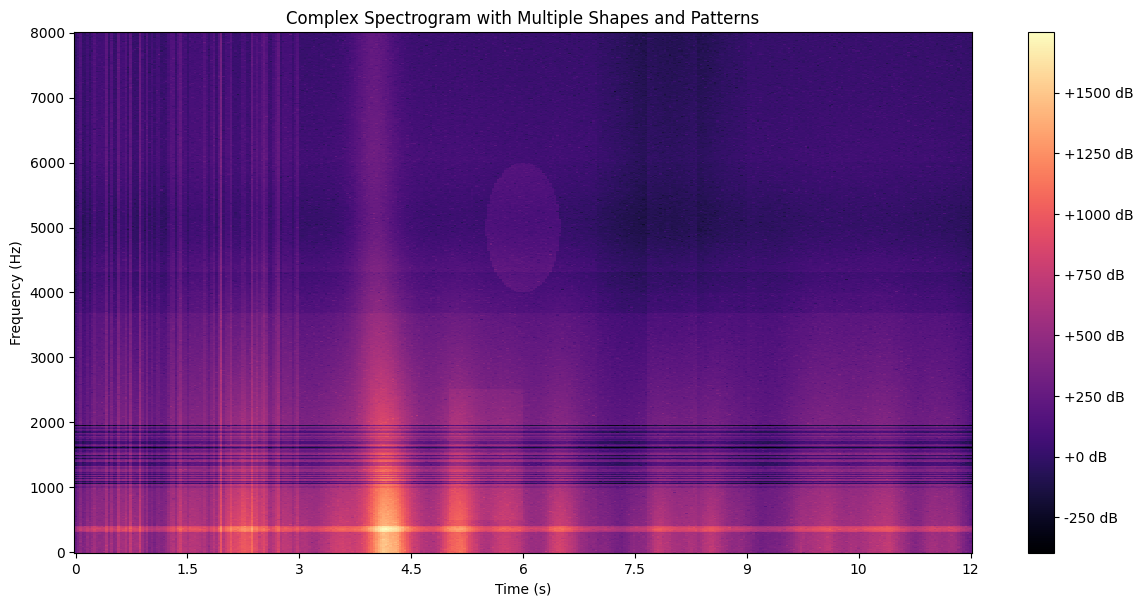

In [217]:
# 사용 예시
sample_rate = 16000
duration = 12
n_samples = sample_rate * duration
np.random.seed(42)
signal = np.random.normal(-80, 1, n_samples)

# spectro_mod = SpectrogramModifier(
#     sample_rate=sample_rate,
#     n_fft=1024,
#     hop_length=512,
#     noise_strength=600,
#     noise_type='perlin',
#     noise_params={'seed': 42, 'scale': 100.0}
# )

spectro_mod = SpectrogramModifier(
    sample_rate=16000,
    n_fft=1024,
    hop_length=512,
    noise_strength=100,    # 노이즈 강도
    noise_type='normal', # 노이즈 타입: 'normal', 'uniform', 'perlin' 등
    noise_params={'mean':1, 'std':50}
)

pipeline = NoisePipeline(spectro_mod)

distribution_engine = DistributionEngine()
# Shape 추가 예시
pipeline.add_shape(
    pipeline.shape_factory.create(
        "circle",
        distribution_engine=distribution_engine,
        center_freq=5000,
        center_time=6.0,
        radius_freq=1000,
        radius_time=0.5,
        strength_dB=100,  # none일 때만 사용
        # distribution_type='normal',
        # distribution_params={'mean':1, 'stddev':100}
    )
)

pipeline.add_shape(
    pipeline.shape_factory.create(
        "rectangle",
        freq_min=500,
        freq_max=2500,
        time_min=5.0,
        time_max=6.0,
        strength_dB=54
    )
)

# 수평선 shape 추가
pipeline.add_shape(
    pipeline.shape_factory.create(
        "horizontal_line",
        center_freq=4000,
        strength_dB=-55,
        thickness=40,
        distribution='normal'
    )
)

# 수직선 shape 추가
pipeline.add_shape(
    pipeline.shape_factory.create(
        "vertical_line",
        center_time=8,
        strength_dB=50,
        thickness=20
    )
)

pipeline.add_pattern(
    pipeline.pattern_factory.create(
        "random",
        {
            'shape_name': 'vertical_line',
            'shape_params': {
                'center_time': 2.0,
                'strength_dB': 60,
                'thickness': 1
            },
            'n': 100,
            'freq_range': (0, 12),   # vertical_line에서는 freq_range 미사용
            'time_range': (0, 3.0)   # 0~3초 사이 랜덤 배치
        }
    )
)


# Pattern 추가 예시 (랜덤 패턴으로 spike 형태 배치)
pipeline.add_pattern(
    pipeline.pattern_factory.create(
        "random",
        {
            'shape_name': 'spike',
            'shape_params': {
                'center_freq': 200,  # 변경: freq -> center_freq
                'center_time': 1.0,   # 변경: time -> center_time
                'radius_freq': 10000,
                'radius_time': 1,
                'strength_dB': 100,
            },
            'n': 100,
            'freq_range': (0, 0),
            'time_range': (0, 12.0)
        }
    )
)


# Pattern 추가 예시 (랜덤 패턴으로 spike 형태 배치)
pipeline.add_pattern(
    pipeline.pattern_factory.create(
        "random",
        {
            'shape_name': 'spike',
            'shape_params': {
                'center_freq': 200,  # 변경: freq -> center_freq
                'center_time': 1.0,   # 변경: time -> center_time
                'radius_freq': 10000,
                'radius_time': 1,
                'strength_dB': 100,
            },
            'n': 100,
            'freq_range': (0, 0),
            'time_range': (0, 12.0)
        }
    )
)

# Pattern 추가 예시 (랜덤 패턴으로 spike 형태 배치)
pipeline.add_pattern(
    pipeline.pattern_factory.create(
        "random",
        {
            'shape_name': 'horizontal_line',
            'shape_params': {
                'center_freq': 200,  # 변경: freq -> center_freq
                'center_time': 1.0,   # 변경: time -> center_time
                'strength_dB': -100,
            },
            'n': 100,
            'freq_range': (1000, 2000),
            'time_range': (0, 12.0)
        }
    )
)


pipeline.add_shape(
    pipeline.shape_factory.create(
        "fog",
        strength_dB=1,  # Fog 자체 dB값은 0으로 하고 distribution으로 noisy하게 만듦
        coverage=1.0,    # 스펙트럼 전체 범위 커버
        distribution_type='normal',
        distribution_params={'mean':-5, 'stddev':200}
    )
)

stripe_freq_ranges = [
    {'shape_name': 'horizontal_range_dist_db',
     'freq_min': 300, 'freq_max': 400, 'strength_dB': 300,
     'distribution': 'gaussian', 'distribution_params': {'sigma': 50}},
    {'shape_name': 'horizontal_range_dist_db',
     'freq_min': 4000, 'freq_max': 6000, 'strength_dB': -100,
     'distribution': 'gaussian', 'distribution_params': {'sigma': 500}}
]

stripe_time_ranges = [
    {'shape_name': 'vertical_range_dist_db',
     'time_min': 3, 'time_max': 5, 'strength_dB': 200,
     'distribution': 'gaussian', 'distribution_params': {'sigma': 0.2}},
    {'shape_name': 'vertical_range_dist_db',
     'time_min': 7, 'time_max': 9, 'strength_dB': -150,
     'distribution': 'gaussian', 'distribution_params': {'sigma': 0.5}}
]


for cfg in stripe_time_ranges:
    shape = pipeline.shape_factory.create(
        cfg['shape_name'],
        time_min=cfg['time_min'],
        time_max=cfg['time_max'],
        strength_dB=cfg['strength_dB'],
        distribution=cfg['distribution'],
        distribution_params=cfg['distribution_params']
    )
    pipeline.add_shape(shape)

for cfg in stripe_freq_ranges:
    shape = pipeline.shape_factory.create(
        cfg['shape_name'],
        freq_min=cfg['freq_min'],
        freq_max=cfg['freq_max'],
        strength_dB=cfg['strength_dB'],
        distribution=cfg['distribution'],
        distribution_params=cfg['distribution_params']
    )
    pipeline.add_shape(shape)


result_spectrogram = pipeline.generate(signal)
fig, ax = spectro_mod.plot_spectrogram(
    show_labels=True,
    colormap='magma',
    title='Complex Spectrogram with Multiple Shapes and Patterns'
)
plt.show()


### **모양과 패턴 생성 설명서**

---

### **1. Shape (모양)**

`Shape`는 스펙트로그램에서 특정 영역에 노이즈를 추가하는 기본적인 단위입니다. 아래는 각 `Shape` 클래스와 해당 매개변수에 대한 설명입니다.

---

### **1.1 CircleDBShape**

- **설명**: 원 형태로 노이즈를 추가.
- **매개변수**:
    - `center_freq`: 원의 중심 주파수(Hz).
    - `center_time`: 원의 중심 시간(초).
    - `radius_freq`: 원의 반지름 주파수(Hz).
    - `radius_time`: 원의 반지름 시간(초).
    - `strength_dB`: dB 값의 강도.
    - `distribution_type`: 노이즈 분포 타입. 예) `'normal'`, `'uniform'`, `'none'`.
    - `distribution_params`: 분포에 필요한 추가 매개변수. 예) `{'mean': 0, 'stddev': 1}`.

---

### **1.2 RectangleDBShape**

- **설명**: 직사각형 형태로 노이즈를 추가.
- **매개변수**:
    - `freq_min`: 직사각형의 주파수 최소값(Hz).
    - `freq_max`: 직사각형의 주파수 최대값(Hz).
    - `time_min`: 직사각형의 시간 최소값(초).
    - `time_max`: 직사각형의 시간 최대값(초).
    - `strength_dB`: dB 값의 강도.
    - `distribution_type`: 노이즈 분포 타입.
    - `distribution_params`: 분포에 필요한 추가 매개변수.

---

### **1.3 EllipseDBShape**

- **설명**: 타원 형태로 노이즈를 추가.
- **매개변수**:
    - `center_freq`: 타원의 중심 주파수(Hz).
    - `center_time`: 타원의 중심 시간(초).
    - `radius_freq`: 타원의 반지름 주파수(Hz).
    - `radius_time`: 타원의 반지름 시간(초).
    - `strength_dB`: dB 값의 강도.
    - `distribution_type`: 노이즈 분포 타입.
    - `distribution_params`: 분포에 필요한 추가 매개변수.

---

### **1.4 SpikeDBShape**

- **설명**: 특정 주파수나 시간에 뾰족한 노이즈를 추가.
- **매개변수**:
    - `center_freq`: 스파이크 중심 주파수(Hz).
    - `center_time`: 스파이크 중심 시간(초).
    - `radius_freq`: 스파이크 반지름 주파수(Hz).
    - `radius_time`: 스파이크 반지름 시간(초).
    - `strength_dB`: dB 값의 강도.
    - `rotate`: 회전 각도(도). 예) `(45, 0)`.

---

### **1.5 FogDBShape**

- **설명**: 전체 스펙트로그램에 랜덤 노이즈를 추가.
- **매개변수**:
    - `strength_dB`: 노이즈 강도.
    - `coverage`: 스펙트로그램을 덮을 비율(0~1).
    - `distribution_type`: 노이즈 분포 타입.
    - `distribution_params`: 분포에 필요한 추가 매개변수.

---

### **1.6 HorizontalLineDBShape**

- **설명**: 주파수 축에 수평선 형태로 노이즈 추가.
- **매개변수**:
    - `center_freq`: 수평선 중심 주파수(Hz).
    - `strength_dB`: 노이즈 강도.
    - `thickness`: 선의 두께.

---

### **1.7 VerticalLineDBShape**

- **설명**: 시간 축에 수직선 형태로 노이즈 추가.
- **매개변수**:
    - `center_time`: 수직선 중심 시간(초).
    - `strength_dB`: 노이즈 강도.
    - `thickness`: 선의 두께.

---

### **1.8 TrapezoidDBShape**

- **설명**: 사다리꼴 형태로 노이즈 추가.
- **매개변수**:
    - `freq_min`, `freq_max`: 주파수 범위(Hz).
    - `time_min`, `time_max`: 시간 범위(초).
    - `slope_freq`, `slope_time`: 사다리꼴 기울기.
    - `strength_dB`: 노이즈 강도.

---

### **1.9 PolygonDBShape**

- **설명**: 다각형 형태로 노이즈 추가.
- **매개변수**:
    - `vertices`: 다각형 꼭짓점 리스트. 예) `[(1000, 2.0), (2000, 4.0), (1500, 3.0)]`.
    - `strength_dB`: 노이즈 강도.

---

### **2. Pattern (패턴)**

`Pattern`은 Shape를 특정 방식으로 배치하여 노이즈를 패턴화합니다.

---

### **2.1 LinearPattern**

- **설명**: Shape를 일정 간격으로 반복.
- **매개변수**:
    - `shape_name`: 사용할 Shape의 이름. 예) `'circle'`, `'rectangle'`.
    - `shape_params`: Shape 생성에 필요한 매개변수.
    - `direction`: 반복 방향. `'time'` 또는 `'freq'`.
    - `repeat`: 반복 횟수.
    - `spacing`: 반복 간격(초 또는 Hz).

---

### **2.2 RandomPattern**

- **설명**: 특정 구간에서 Shape를 랜덤 위치로 배치.
- **매개변수**:
    - `shape_name`: 사용할 Shape의 이름.
    - `shape_params`: Shape 생성에 필요한 매개변수.
    - `n`: 생성할 Shape 개수.
    - `freq_range`: 주파수 범위. 예) `(500, 5000)`.
    - `time_range`: 시간 범위. 예) `(0, 10)`.

---

### **2.3 NLinearRepeatTSleepPattern**

- **설명**: 일정 간격으로 Shape를 반복하고, 쉬는 시간 추가.
- **매개변수**:
    - `shape_name`: 사용할 Shape의 이름.
    - `shape_params`: Shape 생성에 필요한 매개변수.
    - `repeat`: 반복 횟수.
    - `repeat_time`: 각 반복 간격.
    - `sleep_time`: 쉬는 시간.

---

### **2.4 ConvexPattern**

- **설명**: Shape를 중앙 집중 분포 형태로 배치.
- **매개변수**:
    - `shape_name`: 사용할 Shape의 이름.
    - `shape_params`: Shape 생성에 필요한 매개변수.
    - `freq_min`, `freq_max`: 주파수 범위.
    - `time_min`, `time_max`: 시간 범위.
    - `n`: Shape 생성 개수.

---

### **2.5 FunctionPattern**

- **설명**: 사용자 정의 함수 기반으로 노이즈 추가.
- **매개변수**:
    - `func`: callable 함수. `func(freqs, times)` 형태로 구현.

---

### **노이즈 분포(Distribution)**

모든 Shape와 Pattern에 사용할 수 있는 분포입니다.

| 분포 타입 (`distribution_type`) | 매개변수 (`distribution_params`) |
| --- | --- |
| `'normal'` | `{'mean': 평균, 'stddev': 표준편차}` |
| `'uniform'` | `{'min': 최소값, 'max': 최대값}` |
| `'poisson'` | `{'lam': 람다(평균값)}` |
| `'laplace'` | `{'loc': 평균, 'scale': 스케일}` |
| `'beta'` | `{'a': 알파, 'b': 베타}` |
| `'gamma'` | `{'shape_param': 형상 매개변수, 'scale': 스케일}` |
| `'chisquare'` | `{'df': 자유도}` |
| `'cauchy'` | 없음 |
| `'exponential'` | `{'scale': 스케일}` |

---

위 설명서를 바탕으로 원하는 모양과 패턴을 조합하여 노이즈를 생성할 수 있습니다.

4o

### 나의 말:

ShapeFactory로 사용하는 법을 알려줘

### ChatGPT의 말:

ChatGPT

`ShapeFactory`는 `Shape` 객체를 생성하는 데 사용됩니다. 이를 통해 다양한 모양의 `Shape` 객체를 쉽게 생성할 수 있습니다. 아래는 `ShapeFactory`를 사용하는 방법과 주요 개념을 설명합니다.

---

### **ShapeFactory 사용법**

1. **`ShapeFactory` 객체 생성**`ShapeFactory`를 생성할 때 `DistributionEngine`을 전달해야 합니다.
    
    ```python
    python
    코드 복사
    distribution_engine = DistributionEngine()
    shape_factory = ShapeFactory(distribution_engine)
    
    ```
    
2. **`create()` 메서드로 Shape 생성**`create()` 메서드를 호출하여 원하는 `Shape` 객체를 생성합니다.
    
    ```python
    python
    코드 복사
    shape = shape_factory.create(
        shape_name="circle",  # 생성할 Shape 이름
        center_freq=5000,     # Shape의 매개변수
        center_time=6.0,
        radius_freq=1000,
        radius_time=0.5,
        strength_dB=100,
        distribution_type='normal',
        distribution_params={'mean': 0, 'stddev': 5}
    )
    
    ```
    
3. **생성된 Shape를 사용**`NoisePipeline`에 추가하거나 직접 사용해 `SpectrogramModifier`에 마스킹할 수 있습니다.
    
    ```python
    python
    코드 복사
    pipeline.add_shape(shape)
    
    ```
    

---

### **ShapeFactory에서 생성 가능한 Shape**

`ShapeFactory`는 아래의 Shape를 생성할 수 있습니다. `create()` 메서드에서 `shape_name`에 따라 다르게 동작합니다.

---

### **1. CircleDBShape**

```python
python
코드 복사
shape = shape_factory.create(
    shape_name="circle",
    center_freq=5000,         # 원 중심 주파수
    center_time=6.0,          # 원 중심 시간
    radius_freq=1000,         # 반지름 주파수
    radius_time=0.5,          # 반지름 시간
    strength_dB=100,          # 기본 dB 강도
    distribution_type='normal',  # 노이즈 분포 타입 ('none', 'normal', 'uniform' 등)
    distribution_params={'mean': 0, 'stddev': 5}  # 분포 매개변수
)

```

---

### **2. RectangleDBShape**

```python
python
코드 복사
shape = shape_factory.create(
    shape_name="rectangle",
    freq_min=500,            # 직사각형 주파수 최소값
    freq_max=2500,           # 직사각형 주파수 최대값
    time_min=5.0,            # 직사각형 시간 최소값
    time_max=6.0,            # 직사각형 시간 최대값
    strength_dB=54,          # 기본 dB 강도
    distribution_type='uniform',
    distribution_params={'min': -1, 'max': 1}
)

```

---

### **3. EllipseDBShape**

```python
python
코드 복사
shape = shape_factory.create(
    shape_name="ellipse",
    center_freq=1000,         # 타원 중심 주파수
    center_time=2.0,          # 타원 중심 시간
    radius_freq=200,          # 반지름 주파수
    radius_time=1.0,          # 반지름 시간
    strength_dB=70,
    distribution_type='normal',
    distribution_params={'mean': 0, 'stddev': 10}
)

```

---

### **4. SpikeDBShape**

```python
python
코드 복사
shape = shape_factory.create(
    shape_name="spike",
    center_freq=5000,         # 스파이크 중심 주파수
    center_time=3.0,          # 스파이크 중심 시간
    radius_freq=500,          # 반지름 주파수
    radius_time=0.2,          # 반지름 시간
    strength_dB=80,
    rotate=(45, 0),           # 회전 각도 (도)
    distribution_type='laplace',
    distribution_params={'loc': 0, 'scale': 1.0}
)

```

---

### **5. HorizontalLineDBShape**

```python
python
코드 복사
shape = shape_factory.create(
    shape_name="horizontal_line",
    center_freq=1500,         # 수평선 중심 주파수
    strength_dB=40,
    thickness=3               # 선의 두께
)

```

---

### **6. VerticalLineDBShape**

```python
python
코드 복사
shape = shape_factory.create(
    shape_name="vertical_line",
    center_time=2.5,          # 수직선 중심 시간
    strength_dB=30,
    thickness=2               # 선의 두께
)

```

---

### **7. TrapezoidDBShape**

```python
python
코드 복사
shape = shape_factory.create(
    shape_name="trapezoid",
    freq_min=100,             # 주파수 최소값
    freq_max=500,             # 주파수 최대값
    time_min=2.0,             # 시간 최소값
    time_max=5.0,             # 시간 최대값
    slope_freq=0.5,           # 주파수 기울기
    slope_time=0.2,           # 시간 기울기
    strength_dB=60
)

```

---

### **8. FogDBShape**

```python
python
코드 복사
shape = shape_factory.create(
    shape_name="fog",
    strength_dB=5,            # 기본 dB 값
    coverage=0.8,             # 스펙트로그램 커버 비율
    distribution_type='normal',
    distribution_params={'mean': 0, 'stddev': 0.5}
)

```

---

### **9. PolygonDBShape**

```python
python
코드 복사
shape = shape_factory.create(
    shape_name="polygon",
    vertices=[(1000, 1.0), (2000, 2.0), (1500, 3.0)],  # 다각형 꼭짓점 좌표
    strength_dB=50
)

```

---

### **ShapeFactory 코드 사용 요약**

- `ShapeFactory`로 `create()` 메서드 호출 시 `shape_name`과 해당 `Shape`의 매개변수를 제공합니다.
- **반드시 필요한 매개변수**는 각 Shape의 설명에 나열된 필드를 참고하세요.
- 생성된 Shape는 `NoisePipeline`에 추가하거나 별도로 사용할 수 있습니다.

Shape 'fog' 생성 중 예외 발생: name 'shape_factory' is not defined. 제공된 파라미터: {'strength_dB': 2.399842614660866, 'coverage': 0.5734746227780236, 'distribution_type': 'normal', 'distribution_params': {'mean': -4.956956214105151, 'stddev': 50.75651835885984}}
Shape 'horizontal_line' 생성 중 예외 발생: name 'shape_factory' is not defined. 제공된 파라미터: {'center_freq': 759.2667109828909, 'strength_dB': 57.34323837249755, 'thickness': 37, 'distribution_type': 'normal', 'distribution_params': {'mean': -1.3209892151307239, 'stddev': 44.75360831544914}}
Shape 'horizontal_line' 생성 중 예외 발생: name 'shape_factory' is not defined. 제공된 파라미터: {'center_freq': 1638.5441514041258, 'strength_dB': 20.876398717461555, 'thickness': 35, 'distribution_type': 'normal', 'distribution_params': {'mean': -0.3570428842322233, 'stddev': 22.160038370582246}}
Pattern 'linear' 생성 중 예외 발생: name 'pattern_factory' is not defined. 제공된 파라미터: {'shape_name': 'horizontal_range_dist_db', 'shape_params': {'freq_min': 335.11161774484805, 'freq_max'

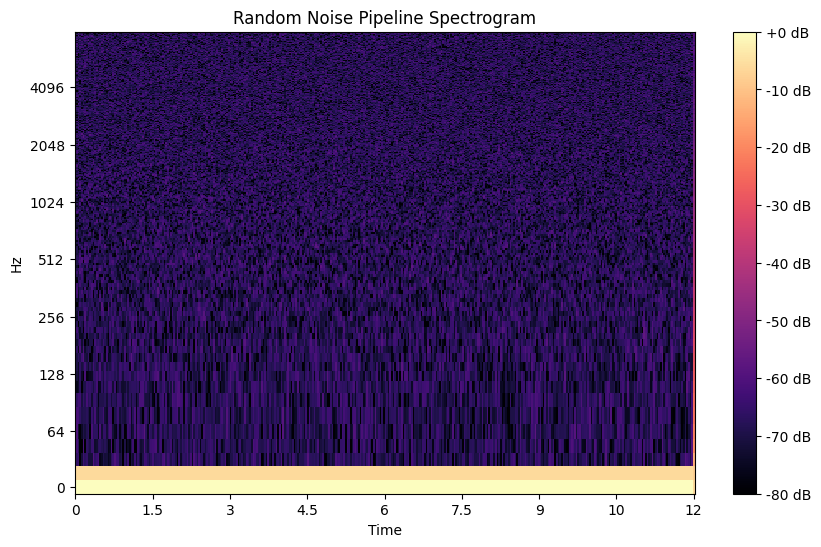

In [1]:
# -*- coding: utf-8 -*-
"""
무작위 노이즈 파이프라인 생성 예시.
PEP 8 스타일과 한글 주석을 준수.
각 Shape/Pattern을 무작위 선택하여 파이프라인에 추가 후,
오디오 신호에 랜덤 노이즈를 입히고 최종 스펙트로그램을 얻는다.

참고 자료:
- librosa: https://librosa.org/doc/latest/
- scipy.ndimage: https://docs.scipy.org/doc/scipy/reference/ndimage.html
"""

import random
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from abc import ABC, abstractmethod
from scipy.ndimage import gaussian_filter

# --- 클래스 정의 ---

class SpectrogramModifier:
    def __init__(self, sample_rate, n_fft, hop_length, noise_strength, noise_type, noise_params):
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.noise_strength = noise_strength
        self.noise_type = noise_type
        self.noise_params = noise_params
        self.S_db = None

    def compute_spectrogram(self, signal):
        S = librosa.stft(signal, n_fft=self.n_fft, hop_length=self.hop_length)
        S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
        self.S_db = S_db.copy()
        return S_db

    def apply_dB_mask(self, mask):
        self.S_db += mask

    def _get_freqs(self):
        return librosa.fft_frequencies(sr=self.sample_rate, n_fft=self.n_fft)

    def _get_times(self):
        return librosa.frames_to_time(np.arange(self.S_db.shape[1]), sr=self.sample_rate, hop_length=self.hop_length, n_fft=self.n_fft)

    def plot_spectrogram(self, show_labels=True, colormap='viridis', title='Spectrogram'):
        plt.figure(figsize=(10, 6))
        librosa.display.specshow(self.S_db, sr=self.sample_rate, hop_length=self.hop_length, x_axis='time', y_axis='log', cmap=colormap)
        if show_labels:
            plt.colorbar(format="%+2.0f dB")
            plt.title(title)
        return plt.gcf(), plt.gca()

class DistributionEngine:
    def __init__(self):
        pass

    def get_distribution(self, distribution_type, params):
        if distribution_type == 'gaussian':
            mean = params.get('mean', 0)
            std = params.get('std', 1)
            return np.random.normal(mean, std, size=params.get('size'))
        elif distribution_type == 'uniform':
            low = params.get('low', 0)
            high = params.get('high', 1)
            return np.random.uniform(low, high, size=params.get('size'))
        # Add more distributions as needed
        else:
            return np.zeros(params.get('size'))

class BaseShape(ABC):
    def __init__(self, distribution_type='none', distribution_params=None):
        self.distribution_type = distribution_type
        self.distribution_params = distribution_params if distribution_params else {}

    @abstractmethod
    def generate_shape_mask(self, spectro_shape, spectro_mod):
        pass

    def create_mask(self, spectro_shape, spectro_mod):
        mask = self.generate_shape_mask(spectro_shape, spectro_mod)
        # Apply distribution if needed
        if self.distribution_type != 'none':
            distribution = DistributionEngine().get_distribution(self.distribution_type, {**self.distribution_params, 'size': spectro_shape})
            mask += distribution
        return mask

class CircleDBShape(BaseShape):
    def __init__(self, center_freq, center_time, radius_freq, radius_time, strength_dB,
                 distribution_type='none', distribution_params=None):
        super().__init__(distribution_type, distribution_params)
        self.center_freq = center_freq
        self.center_time = center_time
        self.radius_freq = radius_freq
        self.radius_time = radius_time
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')
        dist = ((ff - self.center_freq)**2 / (self.radius_freq**2) +
                (tt - self.center_time)**2 / (self.radius_time**2))
        
        # 부드러운 경계를 위한 감쇠 함수 적용 (Gaussian)
        sigma = 0.5  # 감쇠 정도 조절
        mask = np.exp(-dist**2 / (2 * sigma**2))
        
        return mask * self.strength_dB

class RectangleDBShape(BaseShape):
    def __init__(self, freq_min, freq_max, time_min, time_max, strength_dB,
                 distribution_type='none', distribution_params=None):
        super().__init__(distribution_type, distribution_params)
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.time_min = time_min
        self.time_max = time_max
        self.strength_dB = strength_dB

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        freqs = spectro_mod._get_freqs()
        times = spectro_mod._get_times()
        ff, tt = np.meshgrid(freqs, times, indexing='ij')
        
        # 사각형 내부에 대한 이진 마스크
        mask = np.zeros(spectro_shape)
        mask += (self.freq_min <= ff) & (ff <= self.freq_max) & (self.time_min <= tt) & (tt <= self.time_max)
        
        # 부드러운 경계를 위한 거리 기반 감쇠 함수 적용
        edge_width = 100  # 가장자리 감쇠 폭
        mask = mask.astype(float)
        mask = np.minimum(mask, 1 - np.minimum(
            (ff - self.freq_min) / edge_width, 
            (self.freq_max - ff) / edge_width,
            (tt - self.time_min) / edge_width,
            (self.time_max - tt) / edge_width
        ))
        mask = np.clip(mask, 0, 1)
        
        return mask * self.strength_dB

class HorizontalLineDBShape(BaseShape):
    def __init__(self, center_freq, strength_dB, thickness=1,
                 distribution_type='none', distribution_params=None):
        super().__init__(distribution_type, distribution_params)
        self.center_freq = center_freq
        self.strength_dB = strength_dB
        self.thickness = thickness

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        freqs = spectro_mod._get_freqs()
        ff, tt = np.meshgrid(freqs, spectro_mod._get_times(), indexing='ij')
        distance = np.abs(ff - self.center_freq)
        sigma = self.thickness / 3  # Adjust sigma based on thickness
        mask += self.strength_dB * np.exp(-(distance**2) / (2 * sigma**2))
        return mask

class VerticalLineDBShape(BaseShape):
    def __init__(self, center_time, strength_dB, thickness=1,
                 distribution_type='none', distribution_params=None):
        super().__init__(distribution_type, distribution_params)
        self.center_time = center_time
        self.strength_dB = strength_dB
        self.thickness = thickness

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        times = spectro_mod._get_times()
        tt, ff = np.meshgrid(times, spectro_mod._get_freqs(), indexing='ij')
        distance = np.abs(tt - self.center_time)
        sigma = self.thickness / 3  # Adjust sigma based on thickness
        mask += self.strength_dB * np.exp(-(distance**2) / (2 * sigma**2))
        return mask

class FogDBShape(BaseShape):
    def __init__(self, strength_dB, coverage=1.0,
                 distribution_type='none', distribution_params=None):
        super().__init__(distribution_type, distribution_params)
        self.strength_dB = strength_dB
        self.coverage = coverage

    def generate_shape_mask(self, spectro_shape, spectro_mod):
        mask = np.zeros(spectro_shape)
        mask += self.strength_dB * self.coverage
        return mask

# ... 추가적인 Shape 클래스 정의 (EllipseDBShape, SpikeDBShape 등) ...

class ShapeFactory:
    def __init__(self, distribution_engine):
        self.distribution_engine = distribution_engine

    def create(self, shape_name, **kwargs):
        if shape_name == "circle":
            return CircleDBShape(
                center_freq=kwargs['center_freq'],
                center_time=kwargs['center_time'],
                radius_freq=kwargs['radius_freq'],
                radius_time=kwargs['radius_time'],
                strength_dB=kwargs['strength_dB'],
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "rectangle":
            return RectangleDBShape(
                freq_min=kwargs['freq_min'],
                freq_max=kwargs['freq_max'],
                time_min=kwargs['time_min'],
                time_max=kwargs['time_max'],
                strength_dB=kwargs['strength_dB'],
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "horizontal_line":
            return HorizontalLineDBShape(
                center_freq=kwargs['center_freq'],
                strength_dB=kwargs['strength_dB'],
                thickness=kwargs.get('thickness', 1),
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "vertical_line":
            return VerticalLineDBShape(
                center_time=kwargs['center_time'],
                strength_dB=kwargs['strength_dB'],
                thickness=kwargs.get('thickness', 1),
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "fog":
            return FogDBShape(
                strength_dB=kwargs['strength_dB'],
                coverage=kwargs.get('coverage', 1.0),
                distribution_type=kwargs.get('distribution_type', 'none'),
                distribution_params=kwargs.get('distribution_params', None)
            )
        elif shape_name == "horizontal_range_dist_db":
            return HorizontalRangeDistributionDBShape(
                freq_min=kwargs['freq_min'],
                freq_max=kwargs['freq_max'],
                strength_dB=kwargs['strength_dB'],
                distribution=kwargs.get('distribution', 'gaussian'),
                distribution_params=kwargs.get('distribution_params', {})
            )
        elif shape_name == "vertical_range_dist_db":
            return VerticalRangeDistributionDBShape(
                time_min=kwargs['time_min'],
                time_max=kwargs['time_max'],
                strength_dB=kwargs['strength_dB'],
                distribution=kwargs.get('distribution', 'gaussian'),
                distribution_params=kwargs.get('distribution_params', {})
            )
        else:
            raise ValueError(f"Unknown shape name: {shape_name}")

# ... 추가적인 Shape 클래스와 Factory 정의 ...

class Pattern(ABC):
    @abstractmethod
    def create_mask(self, spectro_shape, spectro_mod, shape_factory, distribution_engine):
        pass

class RandomPattern(Pattern):
    def __init__(self, shape_name, shape_params, n, freq_range, time_range):
        self.shape_name = shape_name
        self.shape_params = shape_params
        self.n = n
        self.freq_range = freq_range
        self.time_range = time_range

    def create_mask(self, spectro_shape, spectro_mod, shape_factory, distribution_engine):
        mask = np.zeros(spectro_shape)
        for _ in range(self.n):
            try:
                # 랜덤 위치 설정
                self.shape_params['center_freq'] = random.uniform(*self.freq_range)
                self.shape_params['center_time'] = random.uniform(*self.time_range)
                shape = shape_factory.create(self.shape_name, **self.shape_params)
                mask += shape.create_mask(spectro_shape, spectro_mod)
            except KeyError as e:
                print(f"Pattern 생성 중 KeyError 발생: {e}. 파라미터: {self.shape_params}")
            except Exception as e:
                print(f"Pattern 생성 중 예외 발생: {e}. 파라미터: {self.shape_params}")
        return mask

# ... 추가적인 Pattern 클래스 정의 (LinearPattern, ConvexPattern 등) ...

class PatternFactory:
    def create(self, pattern_name, params):
        if pattern_name == "random":
            return RandomPattern(
                shape_name=params['shape_name'],
                shape_params=params['shape_params'],
                n=params['n'],
                freq_range=params['freq_range'],
                time_range=params['time_range']
            )
        # elif pattern_name == "linear":
            # LinearPattern 생성
        # elif pattern_name == "convex":
            # ConvexPattern 생성
        else:
            raise ValueError(f"Unknown pattern name: {pattern_name}")

# ... 추가적인 PatternFactory 정의 ...

class NoisePipeline:
    def __init__(self, spectro_mod, apply_blur=False, blur_sigma=1.0):
        self.spectro_mod = spectro_mod
        self.distribution_engine = DistributionEngine()
        self.shape_factory = ShapeFactory(self.distribution_engine)
        self.pattern_factory = PatternFactory()
        self.shapes = []
        self.patterns = []
        self.apply_blur = apply_blur
        self.blur_sigma = blur_sigma

    def add_shape(self, shape):
        self.shapes.append(shape)
        return self

    def add_pattern(self, pattern):
        if pattern is not None:
            self.patterns.append(pattern)
        return self

    def generate(self, signal):
        spec = self.spectro_mod.compute_spectrogram(signal)
        total_mask = np.zeros_like(spec)
        for shape in self.shapes:
            shape_mask = shape.create_mask(spec.shape, self.spectro_mod)
            total_mask += shape_mask
        for pattern in self.patterns:
            pattern_mask = pattern.create_mask(spec.shape, self.spectro_mod, self.shape_factory, self.distribution_engine)
            total_mask += pattern_mask
        if self.apply_blur:
            total_mask = gaussian_filter(total_mask, sigma=self.blur_sigma)
        self.spectro_mod.apply_dB_mask(total_mask)
        return self.spectro_mod.S_db

# --- 헬퍼 함수 ---

def generate_shape_params(shape_name):
    """
    주어진 shape_name에 따라 필요한 파라미터를 생성하여 반환한다.
    """
    params = {}
    if shape_name in ["circle", "ellipse", "spike"]:
        params.update({
            "center_freq": random.uniform(200, 6000),
            "center_time": random.uniform(0.0, 12.0),
            "radius_freq": random.uniform(100, 2000),
            "radius_time": random.uniform(0.1, 2.0),
            "strength_dB": random.uniform(-50, 100)
        })
        if shape_name == "spike":
            params["rotate"] = (random.uniform(0, 180), 0)
    elif shape_name == "rectangle":
        params.update({
            "freq_min": random.uniform(100, 1000),
            "freq_max": random.uniform(1001, 8000),
            "time_min": random.uniform(0.0, 6.0),
            "time_max": random.uniform(6.1, 12.0),
            "strength_dB": random.uniform(-50, 100)
        })
    elif shape_name == "pillar":
        params.update({
            "freq_min": random.uniform(300, 3000),
            "freq_max": random.uniform(3001, 8000),
            "strength_dB": random.uniform(-50, 100)
        })
    elif shape_name == "horizontal_line":
        params.update({
            "center_freq": random.uniform(300, 7000),
            "strength_dB": random.uniform(-50, 100),
            "thickness": random.randint(1, 50),
            "distribution_type": "normal",
            "distribution_params": {
                "mean": random.uniform(-5, 0),
                "stddev": random.uniform(10, 50)
            }
        })
    elif shape_name == "vertical_line":
        params.update({
            "center_time": random.uniform(0.0, 12.0),
            "strength_dB": random.uniform(-50, 100),
            "thickness": random.randint(1, 50),
            "distribution_type": "normal",
            "distribution_params": {
                "mean": random.uniform(-5, 0),
                "stddev": random.uniform(10, 50)
            }
        })
    elif shape_name == "fog":
        params.update({
            "strength_dB": random.uniform(-10, 10),
            "coverage": random.uniform(0.5, 1.0),
            "distribution_type": "normal",
            "distribution_params": {
                "mean": random.uniform(-5, 0),
                "stddev": random.uniform(50, 200)
            }
        })
    elif shape_name == "horizontal_range_dist_db":
        params.update({
            "freq_min": random.uniform(300, 400),
            "freq_max": random.uniform(400, 6000),
            "strength_dB": random.uniform(-100, 300),
            "distribution": "gaussian",
            "distribution_params": {
                "sigma": random.uniform(50, 500)
            }
        })
    elif shape_name == "vertical_range_dist_db":
        params.update({
            "time_min": random.uniform(3.0, 7.0),
            "time_max": random.uniform(5.0, 9.0),
            "strength_dB": random.uniform(-150, 200),
            "distribution": "gaussian",
            "distribution_params": {
                "sigma": random.uniform(0.2, 0.5)
            }
        })
    else:
        print(f"알 수 없는 shape_name: {shape_name}")
    return params

def create_random_noise_pipeline(
    spectro_mod,
    max_shapes=5,
    max_patterns=3
):
    """
    무작위로 Shape와 Pattern을 골라 파이프라인에 추가한다.
    max_shapes, max_patterns는 추가할 Shape/Pattern 개수의 최대값.
    """
    pipeline = NoisePipeline(spectro_mod, apply_blur=True, blur_sigma=2.0)
    
    # 사용할 수 있는 shape_name 목록
    possible_shapes = [
        "circle", "rectangle", "ellipse", "spike",
        "fog", "pillar", "horizontal_line", "vertical_line",
        "horizontal_range_dist_db", "vertical_range_dist_db"
    ]

    # 사용할 수 있는 pattern_name 목록
    possible_patterns = [
        "linear", "random", "n_linear_repeat_t_time_sleep", "convex"
    ]

    # Shape 무작위 추가
    num_shapes = random.randint(1, max_shapes)
    for _ in range(num_shapes):
        shape_name = random.choice(possible_shapes)
        shape_kwargs = generate_shape_params(shape_name)

        # 'generate_shape_params'가 빈 dict를 반환할 경우 스킵
        if not shape_kwargs:
            print(f"Shape '{shape_name}'을 생성할 수 없습니다. 필요한 파라미터가 누락되었습니다.")
            continue

        try:
            shape = shape_factory.create(shape_name, **shape_kwargs)
            pipeline.add_shape(shape)
            print(f"Shape '{shape_name}'이 성공적으로 추가되었습니다.")
        except KeyError as e:
            print(f"Shape '{shape_name}' 생성 중 KeyError 발생: {e}. 제공된 파라미터: {shape_kwargs}")
        except Exception as e:
            print(f"Shape '{shape_name}' 생성 중 예외 발생: {e}. 제공된 파라미터: {shape_kwargs}")

    # Pattern 무작위 추가
    num_patterns = random.randint(1, max_patterns)
    for _ in range(num_patterns):
        pattern_name = random.choice(possible_patterns)
        pattern_kwargs = {}

        if pattern_name == "linear":
            selected_shape = random.choice(possible_shapes)
            pattern_kwargs.update({
                "shape_name": selected_shape,
                "shape_params": generate_shape_params(selected_shape),
                "direction": random.choice(["time", "freq"]),
                "repeat": random.randint(2, 5),
                "spacing": random.uniform(0.5, 2.0)
            })

        elif pattern_name == "random":
            selected_shape = random.choice(possible_shapes)
            pattern_kwargs.update({
                "shape_name": selected_shape,
                "shape_params": generate_shape_params(selected_shape),
                "n": random.randint(5, 30),
                "freq_range": (0, 8000),
                "time_range": (0, 12.0)
            })

        elif pattern_name == "n_linear_repeat_t_time_sleep":
            selected_shape = random.choice(possible_shapes)
            pattern_kwargs.update({
                "shape_name": selected_shape,
                "shape_params": generate_shape_params(selected_shape),
                "repeat": random.randint(2, 5),
                "repeat_time": random.uniform(0.1, 1.0),
                "sleep_time": random.uniform(1, 5),
                "start_time": random.uniform(0, 2.0)
            })

        elif pattern_name == "convex":
            selected_shape = random.choice(possible_shapes)
            pattern_kwargs.update({
                "shape_name": selected_shape,
                "shape_params": generate_shape_params(selected_shape),
                "freq_min": random.uniform(100, 200),
                "freq_max": random.uniform(2001, 6000),
                "time_min": random.uniform(0, 2),
                "time_max": random.uniform(2, 10),
                "n": random.randint(5, 15)
            })

        else:
            print(f"알 수 없는 pattern_name: {pattern_name}, 스킵합니다.")
            continue  # 알 수 없는 패턴은 스킵

        # 'shape_params'가 비어있을 경우 스킵
        if not pattern_kwargs.get("shape_params"):
            print(f"Pattern '{pattern_name}'을 생성할 수 없습니다. 필요한 파라미터가 누락되었습니다.")
            continue

        try:
            pattern = pattern_factory.create(pattern_name, pattern_kwargs)
            pipeline.add_pattern(pattern)
            print(f"Pattern '{pattern_name}'이 성공적으로 추가되었습니다.")
        except KeyError as e:
            print(f"Pattern '{pattern_name}' 생성 중 KeyError 발생: {e}. 제공된 파라미터: {pattern_kwargs}")
        except Exception as e:
            print(f"Pattern '{pattern_name}' 생성 중 예외 발생: {e}. 제공된 파라미터: {pattern_kwargs}")

    return pipeline

# --- 메인 함수 ---

def main():
    """
    메인 함수: 무작위 파이프라인을 생성하여 오디오 신호에 노이즈를 더한 뒤,
    스펙트로그램을 그려본다.
    """
    sr = 16000
    duration = 12
    n_samples = sr * duration
    # 재현 가능성을 위해 시드 설정
    # random.seed(42)
    # np.random.seed(42)
    # 예시용 신호
    signal = np.random.normal(-80, 1, n_samples)

    # SpectrogramModifier 초기화
    spectro_mod = SpectrogramModifier(
        sample_rate=sr,
        n_fft=1024,
        hop_length=512,
        noise_strength=50,  # 노이즈 강도
        noise_type='normal',  # 노이즈 타입: 'normal', 'uniform', 'perlin' 등
        noise_params={'mean': 0, 'std': 10}
    )

    # NoisePipeline 초기화 (블러 적용)
    pipeline = NoisePipeline(spectro_mod, apply_blur=True, blur_sigma=2.0)

    # 무작위 파이프라인 생성
    pipeline = create_random_noise_pipeline(
        spectro_mod,
        max_shapes=3,
        max_patterns=2
    )

    # 파이프라인 실행
    try:
        result_spectrogram = pipeline.generate(signal)
    except KeyError as e:
        print(f"파이프라인 실행 중 KeyError 발생: {e}")
    except Exception as e:
        print(f"파이프라인 실행 중 예외 발생: {e}")

    # 결과 스펙트로그램 시각화
    try:
        fig, ax = spectro_mod.plot_spectrogram(
            show_labels=True,
            colormap='magma',
            title='Random Noise Pipeline Spectrogram'
        )
        plt.show()
    except Exception as e:
        print(f"스펙트로그램 시각화 중 예외 발생: {e}")

if __name__ == "__main__":
    main()
